In [1]:
import argparse
import gdown
import cv2
import numpy as np
import os
import sys
sys.path.append(sys.path[0]+"/tracker")
sys.path.append(sys.path[0]+"/tracker/model")
from track_anything import TrackingAnything
from track_anything import parse_augment
import requests
import json
import torchvision
import torch 
from tools.painter import mask_painter
import psutil
import time
try: 
    from mmcv.cnn import ConvModule
except:
    os.system("mim install mmcv")
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils


In [2]:
ovis_anotations = 'D:/HADA/data/OVIS/annotations/'
ovis_images = 'D:/HADA/data/OVIS/train_images/'

ovis_anotations = '../data.nosync/OVIS/annotations/'
ovis_images = '../data.nosync/OVIS/train_images/'

In [3]:
def cargarDatos(ruta_ann):
    with open(ruta_ann + 'annotations_train.json') as f:
        annotationsTrain = json.load(f)

    with open(ruta_ann + 'annotations_valid.json') as f:
        annotationsValid = json.load(f)

    with open(ruta_ann + 'annotations_test.json') as f:
        annotationsTest = json.load(f)

    clases = annotationsTrain['categories']
    vidTrain = annotationsTrain['videos']
    annTrain = annotationsTrain['annotations']
    vidValid = annotationsValid['videos']
    annValid = annotationsValid['annotations']
    vidTest = annotationsTest['videos']
    annTest = annotationsTest['annotations']

    return clases, vidTrain, annTrain, vidValid, annValid, vidTest, annTest

clases, vidTrain, annTrain, vidValid, annValid, vidTest, annTest = cargarDatos(ovis_anotations) 

In [4]:
def annToRLE(ann, frameId):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    h, w = ann['height'], ann['width']
    segm = ann['segmentations'][frameId]
    if segm is None:
        return None
    if type(segm) == "list":
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, h, w)
        rle = maskUtils.merge(rles)
    elif type(segm['counts']) == "list":
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = segm
    return rle


def annToMask(ann, frameId):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = annToRLE(ann, frameId)
    if rle is not None:
        m = maskUtils.decode(rle)
        return m



def combineMasks(masks, width, height):
    # Crear una matriz vacía para la máscara combinada
    combined = np.zeros((height, width), dtype=np.uint8)

    # Combinar las máscaras en la matriz vacía
    for mask in masks:
        combined += mask  # Sumar la máscara a la máscara combinada

    # Aplicar umbral para obtener una única máscara binaria
    combined = np.where(combined > 0, 1, 0)
    return combined

def unifyMasks(masks, width, height):
    # Crear una matriz vacía para la máscara combinada
    unified = np.zeros((height, width), dtype=np.uint8)

    # Combinar las máscaras en la matriz vacía
    for mask in masks:
        unified += mask  # Sumar la máscara a la máscara combinada

    
    return unified

In [5]:
def load_images_from_folder(path,image_files):
    images = []
    for file in image_files:
        img = cv2.imread(os.path.join(path,file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

def load_all_initial_masks_from_dataset():
    all_masks = []
    for video in vidTrain:
        ann = [a for a in annTrain if a['video_id'] == video['id']]
        masks = [annToMask(a, 0) * (i + 1) for i, a in enumerate(ann) if annToMask(a, 0) is not None]
        all_masks.append(unifyMasks(masks, video['width'], video['height']))
    return all_masks

def load_all_masks_for_video(video):
    ann = [a for a in annTrain if a['video_id'] == video['id']]
    all_masks  = []
    for image_num in range(0,video['length']):
        masks = []
        for i, a in enumerate(ann):
            annot = annToMask(a, image_num)
            if annot is not None: masks.append(annot * (i + 1))
        single_mask = unifyMasks(masks, video['width'], video['height'])
        all_masks.append(single_mask)
    return all_masks

def generate_video_from_frames(frames, output_path, fps=30):
    frames = torch.from_numpy(np.asarray(frames))
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    torchvision.io.write_video(output_path, frames, fps=fps, video_codec="libx264")
    return output_path

In [6]:
def calculate_iou(mask1, mask2):
    # Ensure both masks have the same shape
    assert mask1.shape == mask2.shape, "Mask shapes must be the same."

    # Calculate intersection and union for each label
    labels = np.unique(np.concatenate((mask1, mask2)))
    intersection = np.zeros_like(mask1, dtype=np.float32)
    union = np.zeros_like(mask1, dtype=np.float32)
    iou_per_label = {}

    for label in labels:
        mask1_label = mask1 == label
        mask2_label = mask2 == label
        c_intersection = np.logical_and(mask1_label, mask2_label)
        c_union = np.logical_or(mask1_label, mask2_label)
        intersection += c_intersection
        union += c_union
        iou_per_label[label] = np.sum(c_intersection) / np.sum(c_union)

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou, iou_per_label

def compute_f_measure(mask1, mask2):
    # Ensure both masks have the same shape
    assert mask1.shape == mask2.shape, "Mask shapes must be the same."

    # Calculate F-measure for each label
    labels = np.unique(np.concatenate((mask1, mask2)))
    f_measure_per_label = {}

    for label in labels:
        mask1_label = mask1 == label
        mask2_label = mask2 == label

        true_positives = np.logical_and(mask1_label, mask2_label).sum()
        false_positives = np.logical_and(mask1_label, np.logical_not(mask2_label)).sum()
        false_negatives = np.logical_and(np.logical_not(mask1_label), mask2_label).sum()

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)

        f_measure = 2 * (precision * recall) / (precision + recall)
        f_measure_per_label[label] = f_measure

    return f_measure_per_label

In [7]:
def run_model_on_ovis_set(name, model,path_set,videos, annotations, compute_metrics = False,save_masks = False, compute_video = False, verbose = True):
    for video in videos:
        # Load all images as np.array
        if verbose: print('Loading dataset images')
        images = load_images_from_folder(path_set,video['file_names'])

        # Load al poligon of first image to a usable mask
        if verbose: print('Creating first annotated mask for VOS model')
        ann = [a for a in annotations if a['video_id'] == video['id']]
        masks = [(annToMask(a, 0) * (i + 1)) for i, a in enumerate(ann)]
        initial_mask = unifyMasks(masks, video['width'], video['height'])

        #Compute masks for all images
        if verbose:print('Computing all masks')
        model.xmem.clear_memory()
        masks, logits, painted_images = model.generator(images=images[0:3], template_mask=initial_mask)
        model.xmem.clear_memory()  

        if compute_metrics:
            if verbose: print('Computing Metrics')
            ground_truth_masks = load_all_masks_for_video(video)
            for i,(mask_infered, mask_gt) in enumerate(zip(masks[1:],ground_truth_masks[1:])):
                f_measure = compute_f_measure(mask_infered,mask_gt)
                iou, iou_per_label = calculate_iou(mask_infered,mask_gt)
                print(f'Mask {i}: f_mesure{f_measure}, iou {iou}, per label {iou_per_label}')
                
        if compute_video: 
            if verbose: print('Generating video')
            generate_video_from_frames(painted_images, output_path="./result/track/{}.mp4".format('Video1'+name), fps = 30) 

        if save_masks:
            if verbose: print('Saving masks') 
            path_to_masks = './result/mask/{}'.format('Video1'+name)
            if not os.path.exists(path_to_masks): os.makedirs(path_to_masks)
            for i,mask in enumerate(masks): np.save(os.path.join(path_to_masks, '{:05d}.npy'.format(i)), mask)
                
    return masks, logits, painted_images

In [8]:
SAM_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
xmem_checkpoint = "./checkpoints/XMem-s012.pth"
e2fgvi_checkpoint = "./checkpoints/E2FGVI-HQ-CVPR22.pth"
# args = {
#     'use_refinement' : False
#         }
# model = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)
args = {
    'use_refinement' : True,
    'refinement_mode' : 'bbox'
        }
modelSamBbox = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)
# args = {
#     'use_refinement' : True,
#     'refinement_mode' : 'point'
#         }
# modelSamPoint = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)

Initializing BaseSegmenter to cuda:0
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Sam Refinement ACTIVATED. Mode: bbox
load pretrained SPyNet...
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


In [ ]:
masks_refinement_bbox, logits_refinement_bbox, painted_images_refinement_bbox = run_model_on_ovis_set(name = '_bbox_updating_refinement',model = modelSamBbox, path_set = ovis_images,videos = vidTrain[0:1],annotations = annTrain,compute_metrics = False, save_masks=False, compute_video=True)

In [ ]:
masks, logits, painted_images = run_model_on_ovis_set(name = '_no_refinement',model = model, path_set = ovis_images,videos = vidTrain[0:1],annotations = annTrain,compute_metrics = False, save_masks=False, compute_video=False)

In [ ]:
masks_refinement_point, logits_refinement_point, painted_images_refinement_point = run_model_on_ovis_set(name = '_point_refinement',model = modelSamPoint, path_set = ovis_images,videos = vidTrain[0:1],annotations = annTrain,compute_metrics = False, save_masks=False, compute_video=True)

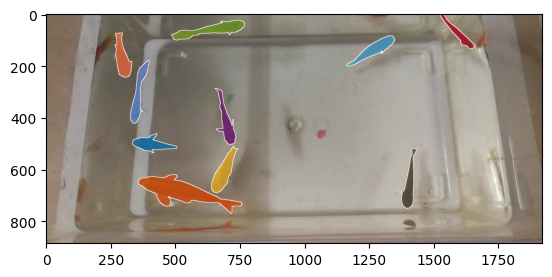

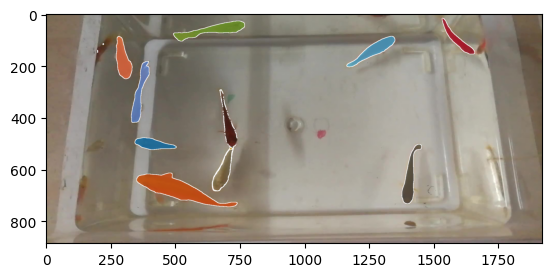

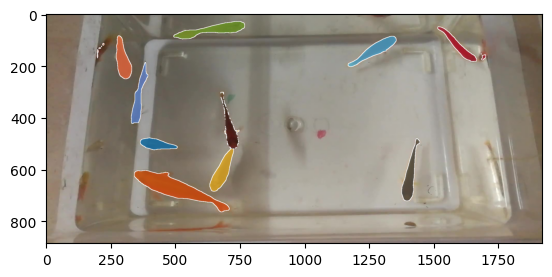

In [10]:
for image in painted_images_refinement_point: 
    plt.imshow(image)
    plt.show()

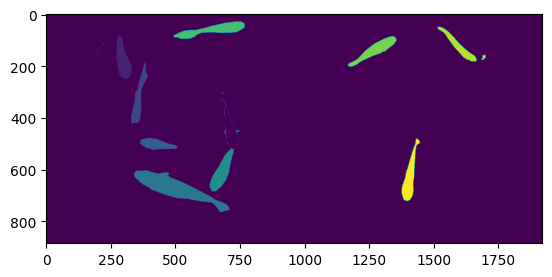

In [19]:
plt.imshow(masks_refinement_point[2])

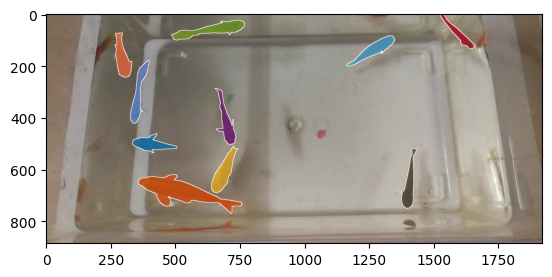

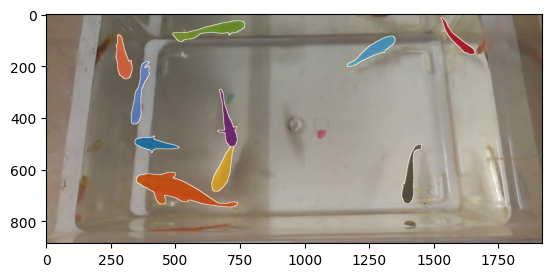

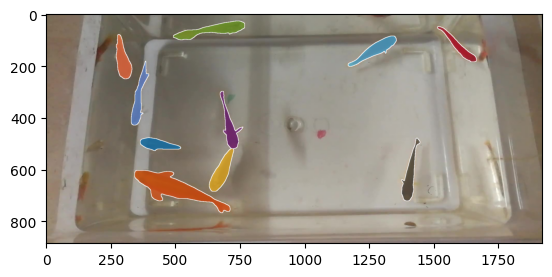

In [12]:
for image in painted_images: 
    plt.imshow(image)
    plt.show()

JUNK TESTING 

In [12]:
images = load_images_from_folder(ovis_images,vidTrain[0]['file_names'][0:10])

In [55]:
def get_best_point_of_interest(segmentation_mask):
    # Find contours in the segmentation mask
    points = []
    contours, _ = cv2.findContours(segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Extract the bounding box coordinates of the contour
        M = cv2.moments(contour)
        points.append([int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])])

    return np.array(points).astype('int')

In [44]:
ann = [a for a in annTrain if a['video_id'] == vidTrain[0]['id']]
masks = [(annToMask(a, 0) * (i + 1)) for i, a in enumerate(ann)]
initial_mask = unifyMasks(masks, vidTrain[0]['width'], vidTrain[0]['height'])

In [56]:
get_best_point_of_interest(masks[4])

array([[687, 612]])

295
[array([[295, 170]])]


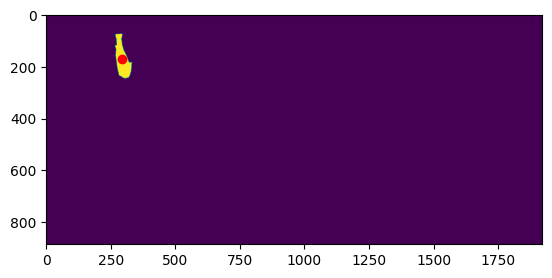

357
[array([[295, 170]]), array([[357, 308]])]


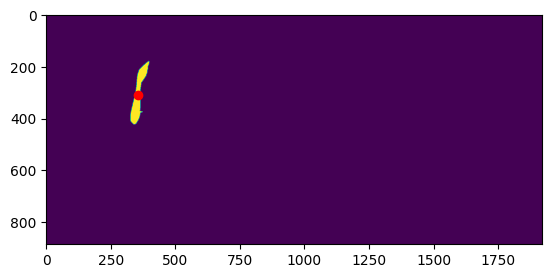

406
[array([[295, 170]]), array([[357, 308]]), array([[406, 503]])]


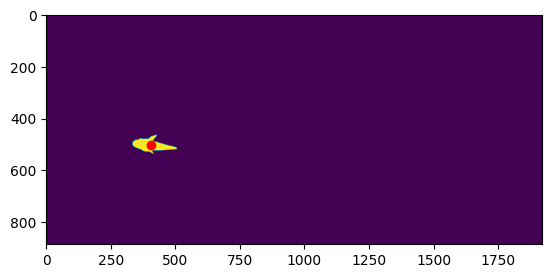

523
[array([[295, 170]]), array([[357, 308]]), array([[406, 503]]), array([[523, 687]])]


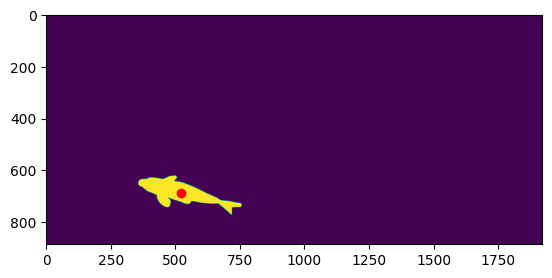

687
[array([[295, 170]]), array([[357, 308]]), array([[406, 503]]), array([[523, 687]]), array([[687, 612]])]


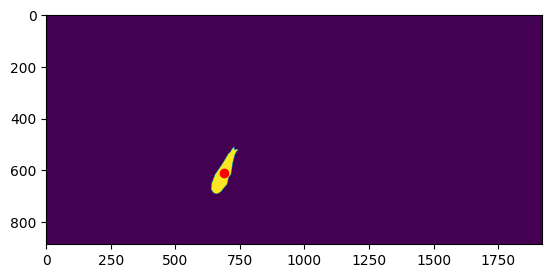

698
[array([[295, 170]]), array([[357, 308]]), array([[406, 503]]), array([[523, 687]]), array([[687, 612]]), array([[698, 420]])]


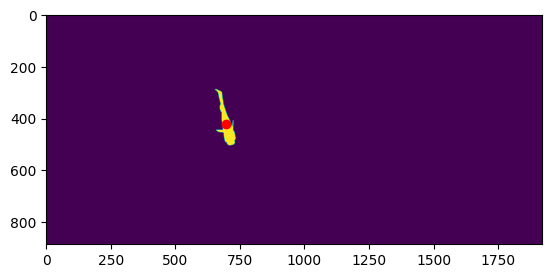

641
[array([[295, 170]]), array([[357, 308]]), array([[406, 503]]), array([[523, 687]]), array([[687, 612]]), array([[698, 420]]), array([[641,  60]])]


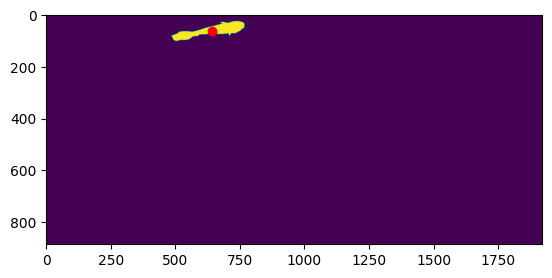

1270
[array([[295, 170]]), array([[357, 308]]), array([[406, 503]]), array([[523, 687]]), array([[687, 612]]), array([[698, 420]]), array([[641,  60]]), array([[1270,  136]])]


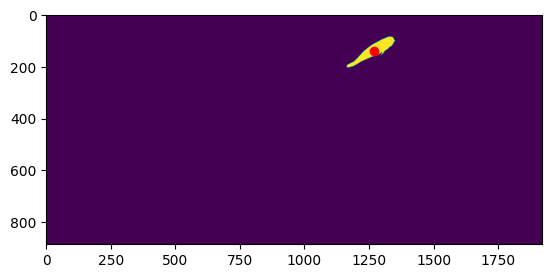

1596
[array([[295, 170]]), array([[357, 308]]), array([[406, 503]]), array([[523, 687]]), array([[687, 612]]), array([[698, 420]]), array([[641,  60]]), array([[1270,  136]]), array([[1596,   76]])]


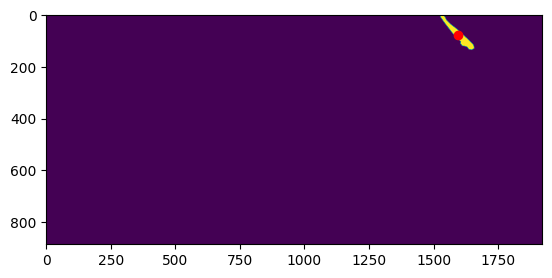

1405
[array([[295, 170]]), array([[357, 308]]), array([[406, 503]]), array([[523, 687]]), array([[687, 612]]), array([[698, 420]]), array([[641,  60]]), array([[1270,  136]]), array([[1596,   76]]), array([[1405,  661]])]


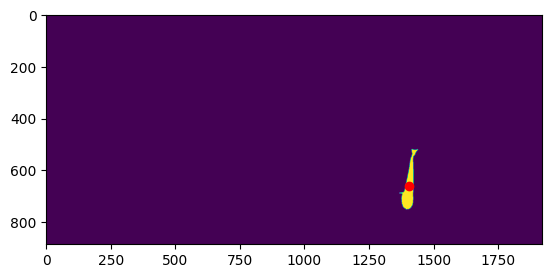

In [59]:
all_points = []
for mask in masks:
    
    points = get_best_point_of_interest(mask)
    all_points.append(points)
    plt.imshow(mask)
    print(points[0][0])
    print(all_points)
    plt.scatter(points[0][0], points[0][1], c='red', marker='o')

    # Set the axis limits
    plt.xlim(0, mask.shape[1])
    plt.ylim(mask.shape[0], 0)

    # Show the plot
    plt.show()

In [82]:
all_points = np.array(all_points).astype('uint8')
all_labels = np.ones((all_points.shape[0],1)).astype('uint8')

In [80]:
modelSam.xmem.sam_model.sam_controler.reset_image()
modelSam.xmem.sam_model.sam_controler.set_image(images[3])

In [83]:
all_points[0]

array([[ 47, 166]], dtype=uint8)

In [85]:
all_labels[0]

array([1], dtype=uint8)

In [ ]:
modelSam.xmem.sam_model.sam_controler.predictor.predict(point_coords=all_points[0], 
                                point_labels=all_labels[0], 
                                multimask_output=False)

In [95]:
all_points[0].shape[0]

1

In [96]:
all_labels[0]

array([1], dtype=uint8)

In [91]:
mode = 'point'
prompts = {
    'point_coords': all_points[0],
    'point_labels': all_labels[0], 
}
modelSam.xmem.sam_model.sam_controler.predict(prompts, mode, multimask=False)

(array([[[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]),
 array([0.9205707], dtype=float32),
 array([[[  2.8117008,   3.4974577,   3.00395  , ...,  -2.6412294,
           -5.4776235,  -5.9374413],
         [ 17.060123 ,  19.839096 ,  21.556105 , ...,  -2.1513772,
           -5.280451 ,  -5.0519924],
         [  8.5573845,  12.134181 ,  10.069857 , ...,  -1.7522925,
           -3.2547555,  -5.0443187],
         ...,
         [-21.253181 , -32.986824 , -21.944582 , ..., -15.822765 ,
          -13.227091 , -15.752703 ],
         [-21.073633 , -21.362463 , -33.053593 , ..., -12.985151 ,
          -17.811558 , -15.261965 ],
         [-14.994264 , -19.94629  , -28.202835 , ..., -14.807328 

In [88]:
modelSam.xmem.sam_model.sam_controler.predictor.predict(point_coords=all_points, 
                                point_labels=all_labels, 
                                multimask_output=False)

RuntimeError: Tensors must have same number of dimensions: got 4 and 3

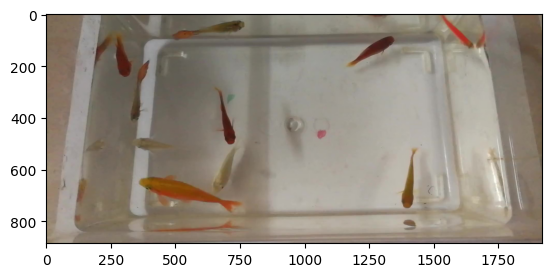

In [20]:
plt.imshow(images[0])

In [ ]:
SAM_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
xmem_checkpoint = "./checkpoints/XMem-s012.pth"
e2fgvi_checkpoint = "./checkpoints/E2FGVI-HQ-CVPR22.pth"
args = {'use_refinement':False}
model = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)
args = {'use_refinement':True}
modelSam = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)

In [ ]:
images = load_images_from_folder(ovis_images,vidTrain[0]['file_names'])
#model.xmem.sam_refinement()

In [ ]:
plt.imshow(images[0])

In [ ]:
ann = [a for a in annTrain if a['video_id'] == vidTrain[0]['id']]
masks = [(annToMask(a, 0) * (i + 1)) for i, a in enumerate(ann)]
initial_mask = unifyMasks(masks, vidTrain[0]['width'], vidTrain[0]['height'])
masks = [(annToMask(a, 0)) for i, a in enumerate(ann)]

In [ ]:
#resized_mask = cv2.resize(masks[3], (256, 256), interpolation=cv2.INTER_NEAREST)

In [ ]:
np.nonzero(masks[3])

In [ ]:
def compute_bounding_box(segmentation_mask):
    # Get the indices where the segmentation mask is non-zero
    nonzero_indices = np.nonzero(segmentation_mask)
    
    # Calculate the bounding box coordinates
    min_row = np.min(nonzero_indices[0])
    max_row = np.max(nonzero_indices[0])
    min_col = np.min(nonzero_indices[1])
    max_col = np.max(nonzero_indices[1])
    
    # Return the bounding box coordinates as a tuple
    bounding_box = [min_col,min_row, max_col, max_row]
    return bounding_box

In [ ]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [ ]:
bboxes = [compute_bounding_box(mask) for mask in masks]

In [ ]:
input_boxes = torch.tensor(bboxes, device=modelSam.xmem.sam_model.sam_controler.predictor.device)

In [ ]:
transformed_boxes = modelSam.xmem.sam_model.sam_controler.predictor.transform.apply_boxes_torch(input_boxes, images[0].shape[:2])

In [ ]:
modelSam.xmem.sam_model.sam_controler.reset_image()
modelSam.xmem.sam_model.sam_controler.set_image(images[0])

In [ ]:
plt.imshow(images[0])
plt.show()
# mask only ------------------------
mode = 'bounding_boxes'
prompts = {'bounding_boxes': transformed_boxes}

masksout, scores, logits = modelSam.xmem.sam_model.sam_controler.predict(prompts, mode, multimask=False)  # masks (n, h, w), scores (n,), logits (n, 256, 256)

In [ ]:
masksout

In [ ]:
pp_mask = np.zeros_like(masksout[0])

In [ ]:
np.unique(pp_mask)

In [ ]:
(masksout[0] * 1 + masksout[1] * 2 )

In [ ]:
pp_mask[masksout[1]] = 2

In [ ]:
masksout[0] == pp_mask

In [ ]:
for i in range(0,len(scores)):
    if i == np.argmax(scores): print('Selected')
    painted_image = mask_painter(images[0], masksout[i][0].numpy().astype('uint8'))
    show_box(input_boxes[i], plt.gca())
    plt.imshow(painted_image)
    plt.show()

In [ ]:

plt.imshow(images[0])
plt.show()
# mask only ------------------------
mode = 'bbox'
prompts = {'bounding_box': transformed_boxes}

masksout, scores, logits = modelSam.xmem.sam_model.sam_controler.predict(prompts, mode, multimask=False)  # masks (n, h, w), scores (n,), logits (n, 256, 256)
for i in range(0,len(scores)):
    if i == np.argmax(scores): print('Selected')
    painted_image = mask_painter(images[1], masksout[i].astype('uint8'))
    show_box(bb, plt.gca())
    plt.imshow(painted_image)
    plt.show()

In [ ]:
modelSam.xmem.sam_model.sam_controler.predictor.transform

In [ ]:
#modelSam.xmem.sam_model.sam_controler.reset_image()
#modelSam.xmem.sam_model.sam_controler.set_image(images[0])
plt.imshow(images[0])

# mask only ------------------------
mode = 'mask'
prompts = {'mask_input': masks[3][None,:,:]}

masks, scores, logits = modelSam.xmem.sam_model.sam_controler.predict(prompts, mode, multimask=True)  # masks (n, h, w), scores (n,), logits (n, 256, 256)
for i in range(0,len(scores)):
    if i == np.argmax(scores): print('Selected')
    painted_image = mask_painter(images[1], masks[i].astype('uint8'))
    plt.imshow(painted_image)
    plt.show()

In [ ]:
model.xmem.clear_memory()
masksout, logitsout, painted_imagesout = model.generator(images=images[0:2], template_mask=initial_mask)
model.xmem.clear_memory() 

In [ ]:
from torchvision.transforms import Resize
resizer = Resize([256, 256])

In [ ]:
ind_logits.shape

In [ ]:
triallogits = logitsout[1][0].unsqueeze(0)
ind_logits = resizer(triallogits).cpu().numpy()

In [ ]:
painted_imagesout[0].shape

In [ ]:
ind_logits.shape

In [ ]:
modelSam.xmem.sam_model.sam_controler.reset_image()
modelSam.xmem.sam_model.sam_controler.set_image(images[0])
plt.imshow(images[0])

# mask only ------------------------
mode = 'mask'
prompts = {'mask_input': ind_logits}

masks, scores, logits = modelSam.xmem.sam_model.sam_controler.predict(prompts, mode, multimask=True)  # masks (n, h, w), scores (n,), logits (n, 256, 256)
for i in range(0,len(scores)):
    if i == np.argmax(scores): print('Selected')
    painted_image = mask_painter(images[1], masks[i].astype('uint8'))
    plt.imshow(painted_image)
    plt.show()

In [ ]:
modelSam.xmem.sam_model.sam_controler.reset_image()

In [ ]:

modelSam.xmem.sam_model.sam_controler.set_image(images[0])
#model.samcontroler.sam_controler.set_image(images[0])
mode = 'point'
prompts = {
    'point_coords': np.array([[500, 650]]),
    'point_labels': np.array([1]), 
}
masks, scores, logits = modelSam.xmem.sam_model.sam_controler.predict(prompts, mode, multimask=False)  # masks (n, h, w), scores (n,), logits (n, 256, 256)
painted_image = mask_painter(images[0], masks[np.argmax(scores)].astype('uint8'))
#cv2.imwrite('/hhd3/gaoshang/truck_point.jpg', painted_image)


plt.imshow(painted_image)
plt.show()

# mask only ------------------------
mode = 'mask'
mask_input  = logits[np.argmax(scores), :, :]

prompts = {'mask_input': mask_input[None, :, :]}
print(prompts['mask_input'].shape)

masks, scores, logits = modelSam.xmem.sam_model.sam_controler.predict(prompts, mode, multimask=True)  # masks (n, h, w), scores (n,), logits (n, 256, 256)
for i in range(0,len(scores)):
    if i == np.argmax(scores): print('Selected')
    painted_image = mask_painter(images[0], masks[i].astype('uint8'))
    plt.imshow(painted_image)
    plt.show()

JUNK

In [ ]:
# Lee una imagen y la muestra en una ventanaovis_images + first_video_folder +'/img_0000001.jpg'
img = cv2.imread(os.path.join(ovis_images + first_video_folder +'/img_0000001.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

In [ ]:
colors = [
    (255, 0, 0),    # Rojo
    (0, 255, 0),    # Verde
    (0, 0, 255),    # Azul
    (255, 255, 0),  # Amarillo
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Cian
    (128, 0, 0),    # Marrón oscuro
    (0, 128, 0),    # Verde oscuro
    (0, 0, 128),    # Azul oscuro
    (128, 128, 0),  # Amarillo oscuro
    (128, 0, 128),  # Magenta oscuro
    (0, 128, 128),  # Cian oscuro
    (255, 128, 0),  # Naranja
    (128, 255, 0),  # Lima
    (255, 0, 128),  # Rosa
    (128, 0, 255),  # Violeta
    (0, 255, 128),  # Turquesa
    (0, 128, 255),  # Azul claro
    (255, 128, 128), # Rosa claro
    (128, 255, 128)  # Verde claro
]

In [ ]:
ann = []
video = vidTrain[0]
for a in annTrain:
    if a['video_id'] == video['id']:
        ann.append(a)
        break
    else: continue

mask = annToMask(ann[0], 0)
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
colored_mask[:, :, 0] = mask * colors[0][0]
colored_mask[:, :, 1] = mask * colors[0][1]
colored_mask[:, :, 2] = mask * colors[0][2]
plt.imshow(colored_mask)

In [ ]:
ann = []
for a in annTrain:
    if a['video_id'] == video['id']:
        ann.append(a)
    else: continue

masks = []
for i,a in enumerate(ann):
    m = annToMask(a, 0)
    m = m * (i + 1)
    masks.append(m)

w, h = video['width'], video['height']
unified = unifyMasks(masks, w, h)

In [ ]:
model.xmem.clear_memory()
masks, logits, painted_images = model.generator(images=images[0:5], template_mask=unified)
model.xmem.clear_memory()

In [ ]:
plt.imshow(painted_images[1])

In [ ]:
def print_rgb_mask(mask):
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    colored_mask[:, :, 0] = mask * colors[0][0]
    colored_mask[:, :, 1] = mask * colors[0][1]
    colored_mask[:, :, 2] = mask * colors[0][2]
    plt.imshow(colored_mask)
    plt.show()
    

In [ ]:
print_rgb_mask(logits[29])